In [31]:
import torch
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [32]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [33]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

print(img.shape)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))

(224, 224, 3)
torch.Size([1, 3, 224, 224])
label=388


In [34]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.001

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())
g=torch.zeros_like(img)

for epoch in range(epochs):
    
    # forward + backward
    output = model(img)

    loss = loss_func(output, target).to(device)
    label=np.argmax(output.data.cpu().numpy())
    
    print("epoch={} loss={} label={}".format(epoch,loss,label))
    
    #如果定向攻击成功
    if label == target:
        print("")
        break
       
    #梯度清零
    model.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    g=0.5*g+img.grad.data/(torch.norm(img.grad.data,p=1))

    img.data=img.data-e*torch.sign(g)


epoch=0 loss=12.660843849182129 label=388
epoch=1 loss=11.619282722473145 label=388
epoch=2 loss=10.70474910736084 label=388
epoch=3 loss=9.910880088806152 label=388
epoch=4 loss=9.246505737304688 label=388
epoch=5 loss=8.696138381958008 label=388
epoch=6 loss=8.249711990356445 label=388
epoch=7 loss=7.86589241027832 label=388
epoch=8 loss=7.52973747253418 label=388
epoch=9 loss=7.233778953552246 label=388
epoch=10 loss=6.954769134521484 label=388
epoch=11 loss=6.679601192474365 label=219
epoch=12 loss=6.387628555297852 label=219
epoch=13 loss=6.106996536254883 label=219
epoch=14 loss=5.8192138671875 label=219
epoch=15 loss=5.49676513671875 label=852
epoch=16 loss=5.1647772789001465 label=852
epoch=17 loss=4.841501712799072 label=852
epoch=18 loss=4.528600692749023 label=852
epoch=19 loss=4.200734615325928 label=852
epoch=20 loss=3.8735055923461914 label=852
epoch=21 loss=3.5596723556518555 label=852
epoch=22 loss=3.2623939514160156 label=293
epoch=23 loss=2.9804394245147705 label=293


(3, 224, 224)


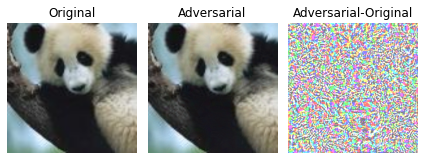

In [35]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,388,adv,target.data.cpu().numpy()[0])